In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/ABRO/"
!ls "drive/My Drive/ABRO/ADNI/"

from IPython.display import clear_output
# !cd "drive/My Drive/ABRO/Atlas/" && unrar e MASKS_MNI2mm.rar

Mounted at /content/drive
AD  CN


In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob


width = 80
height = 80
depth = 60
nLabel = 2

fRange1 = slice(6,86)
fRange2 = slice(16,96)
fRange3 = slice(16,76)

In [3]:
def norm(A):
       return (A-np.amin(A))/(np.amax(A)-np.amin(A))

_data = []
_labels = []
G=glob.glob(data_path+'ADNI/AD/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(1)


G=glob.glob(data_path+'ADNI/CN/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(0)


clear_output()
_data = np.array(_data, dtype=np.float32)#[...,np.newaxis]
_labels = np.array(_labels)

print('_data.shape=>', _data.shape)
print('_labels.shape=>', _labels.shape)

_data.shape=> (145, 80, 80, 60)
_labels.shape=> (145,)


In [4]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical

# oh_labels = to_categorical(_labels)

x_train, x_test, y_train, y_test  = train_test_split(_data, _labels,
                              train_size=.8,random_state=123,shuffle=True)
del _data
del _labels

print('x_train.shape=>', x_train.shape)
print('y_train.shape=>', y_train.shape)
print('x_test.shape=>', x_test.shape)
print('y_test.shape=>', y_test.shape)



x_train.shape=> (116, 80, 80, 60)
y_train.shape=> (116,)
x_test.shape=> (29, 80, 80, 60)
y_test.shape=> (29,)


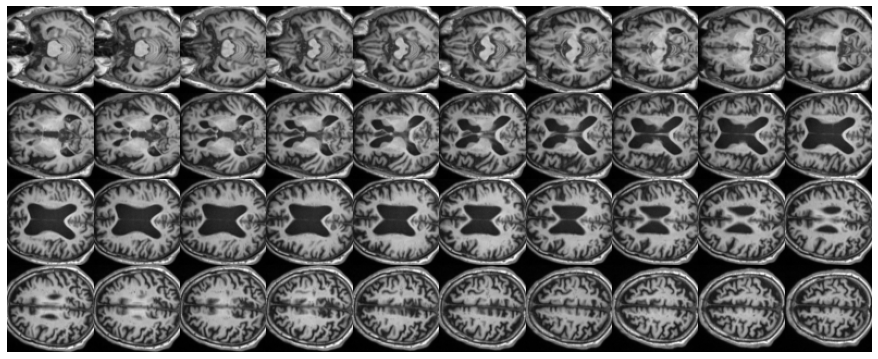

In [5]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.

plot_slices(4, 10, 80, 80,x_train[0][:, :, 10:50])


In [6]:
from tensorflow.python.keras.utils.data_utils import Sequence
import math
from scipy import ndimage
from numpy import random
from tensorflow.keras.preprocessing.image import random_rotation
import tensorflow as tf

def scipy_rotate(volume):
    # define some rotation angles
    angles = [-10, -5, -3, 0, 3, 5, 10]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = random_rotation(volume, angle,row_axis=0,col_axis=1,channel_axis=2)
    return volume


# def scipy_rotate(volume):
#     # define some rotation angles
#     angles = [-10, -5, -3, 0, 3, 5, 10]
#     # pick angles at random
#     angle = random.choice(angles)
#     # rotate volume
#     volume = ndimage.rotate(volume, angle, reshape=False)
#     return volume

class Generator(Sequence):
    # Class is a dataset wrapper for better training performance
    def __init__(self, x_dataset, y_dataset, is_train=True, batch_size=4):
        self.is_train = is_train
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(self.x_dataset))

    def __len__(self):
        return math.ceil(len(self.x_dataset) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
#        print(inds)
        batch_x = self.x_dataset[inds,...]
        if self.is_train:
            for idx in range(len(batch_x)):
                batch_x[idx,...] = scipy_rotate(batch_x[idx,...])
        batch_x = batch_x[...,tf.newaxis]
        batch_y = self.y_dataset[inds]
        return batch_x,batch_y 
    def on_epoch_end(self):
        if self.is_train:
            np.random.shuffle(self.indices)
    


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv3D,MaxPooling3D,Flatten
from tensorflow import keras

def get_model(width=80, height=80, depth=80):
    model = Sequential()
    model.add(keras.Input(shape=(width, height, depth, 1)))
    model.add(Conv3D(64, (3, 3,3),
           activation='relu',
           padding='same',
           name='block1_conv1',
           input_shape=(80,80,80,1)))
    model.add(Conv3D(64, (3, 3,3),
           activation='relu',
           padding='same',
           name='block1_conv2'))
    model.add(MaxPooling3D(
            pool_size=(2, 2,2),
            strides=(2, 2,2),
            name='block1_pool',
            padding='same'
    ))

    model.add(Conv3D(128, (3, 3,3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))
    model.add(Conv3D(128, (3, 3,3),
           activation='relu',
           padding='same',
           name='block2_conv2'))
    model.add(MaxPooling3D((2,2, 2), strides=(2,2, 2),#padding='same',
                           name='block2_pool'
                           ))

    model.add(Conv3D(256, (3, 3,3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))
    model.add(Conv3D(256, (3,3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))
    model.add(Conv3D(256, (3,3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))
    model.add(MaxPooling3D((2,2, 2), strides=(2,2, 2),padding='same', name='block3_pool'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu',name='fc1'))

    model.add(Dense(128, activation='relu',name='fc2'))

    model.add(Dense(1, activation='sigmoid', name='predictions'))
    # print(model.summary())
    return model

In [13]:
# Compile model.
# initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=1000, decay_rate=0.95, staircase=True
# )

tf.random.set_seed(123)

#########################################
train_data_generator = Generator(x_train,y_train)
test_data_generator = Generator(x_test,y_test,is_train=False)

#########################################
model = get_model(width=80, height=80, depth=60)
# model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    data_path+"chkp/3d_MRI_classification_vgg.h5"#, save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_data_generator,
    validation_data=test_data_generator,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)


Epoch 1/50
29/29 - 31s - loss: 0.7925 - acc: 0.4914 - val_loss: 0.6921 - val_acc: 0.5862
Epoch 2/50
29/29 - 30s - loss: 0.6930 - acc: 0.5259 - val_loss: 0.6931 - val_acc: 0.7931
Epoch 3/50
29/29 - 31s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6926 - val_acc: 0.5862
Epoch 4/50
29/29 - 37s - loss: 0.6930 - acc: 0.5690 - val_loss: 0.6925 - val_acc: 0.7241
Epoch 5/50
29/29 - 30s - loss: 0.6918 - acc: 0.6207 - val_loss: 0.6751 - val_acc: 0.6207
Epoch 6/50
29/29 - 37s - loss: 0.6912 - acc: 0.6552 - val_loss: 0.7118 - val_acc: 0.4138
Epoch 7/50
29/29 - 32s - loss: 0.6880 - acc: 0.5690 - val_loss: 0.6206 - val_acc: 0.8276
Epoch 8/50
29/29 - 31s - loss: 0.6707 - acc: 0.6379 - val_loss: 0.6710 - val_acc: 0.5862
Epoch 9/50
29/29 - 34s - loss: 0.6243 - acc: 0.6724 - val_loss: 0.6542 - val_acc: 0.6207
Epoch 10/50
29/29 - 30s - loss: 0.6593 - acc: 0.6552 - val_loss: 0.6603 - val_acc: 0.5862
Epoch 11/50
29/29 - 31s - loss: 0.6729 - acc: 0.5517 - val_loss: 0.6935 - val_acc: 0.4138
Epoch 12/50
29/29 -

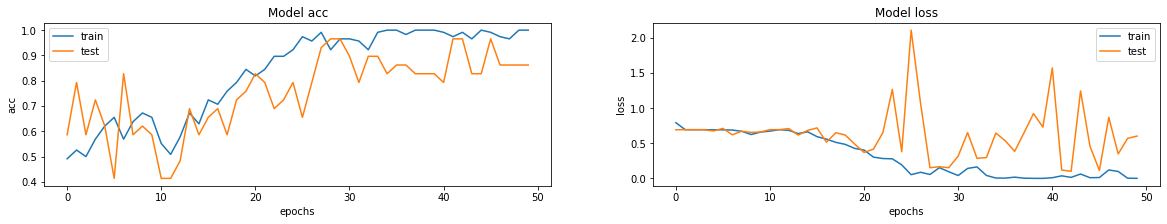

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "test"])


In [9]:
model = get_model(width=80, height=80, depth=60)
# Load best weights.
model.load_weights(data_path+"chkp/3d_MRI_classification_vgg.h5")
prediction = model.predict(x_test[...,np.newaxis]) ##np.expand_dims(x_test[0], axis=0)
# prediction = softmax(prediction) 

# for _p in range(len(prediction)):
#     scores = np.array([1 - prediction[_p], prediction[_p]])
#     class_names = ["normal", "abnormal"]
#     print('Real label is =>',class_names[y_test[_p]])
#     score = scores.max()
#     name = class_names[scores.argmax()]
#     print(
#         "This model is %.2f percent confident that MRI scan is %s"
#         % ((score), name)
#     )
#     print('<##>'*10)


y_pred = np.where(prediction<0.5,0,1)[:,0]
y_true = y_test

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[12  0]
 [ 4 13]]
Accuracy 0.8620689655172413
Precision 1.0
Recall 0.7647058823529411


In [10]:
############################################################################
############################################################################
# def c2rgb(volume,lbl):
#     rgbs = []
#     for _i in range(0,volume.shape[2],3):
#         rgbs.append(volume[...,_i:_i+3])

#     lbl = np.ones(len(rgbs))*lbl
#     return rgbs,lbl

# def convert_to_rgb(x_data,y_data):
#     tmpx = []
#     tmpy = []
#     for xt,yt in zip(x_data,y_data):
#         _x,_y = c2rgb(xt,yt)
#         tmpx.extend(_x)
#         tmpy.extend(_y)

#     tmpx = np.array(tmpx, dtype=np.float32)
#     tmpy = np.array(tmpy, dtype=np.float32)
#     print(tmpx.shape)
#     print(tmpy.shape)
#     return tmpx, tmpy


# x_test, y_test = convert_to_rgb(x_test,y_test)
# x_train, y_train = convert_to_rgb(x_train,y_train)
############################################################################
############################################################################
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.layers.experimental import preprocessing

# input_tensor = keras.Input(shape=(80, 80, 3))

# base_model = ResNet50(weights='imagenet', include_top=False)
# data_augmentation = keras.Sequential(
#     [
#         preprocessing.RandomFlip("horizontal"),
#         preprocessing.RandomRotation(0.1),
#         # preprocessing.RandomZoom(0.1),
#     ]
# )


# model = Sequential()
# model.add(input_tensor)
# model.add(data_augmentation)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# # for layer in base_model.layers:
# #     layer.trainable = False


# model.summary()